<a href="https://colab.research.google.com/github/franroldans/mujoco-robotics-rl/blob/main/DDPG_PER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-dev set to manually installed.
software-properties-common is already the newest version (0.96.24.32.18).
Suggested packages:
  glew-utils
The following NEW packages will be installed:
  libgl1-mesa-glx libglew-dev libglew2.0 libosmesa6 libosmesa6-dev
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,916 kB of archives.
After this operation, 12.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgl1-mesa-glx amd64 20.0.8-0ubuntu1~18.04.1 [5,532 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libglew2.0 amd64 2.0.0-5 [140 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libglew-dev amd64 2.0.0-5 [120 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libosmesa6 amd64 20.0.8-

In [2]:
!pip install gym

In [3]:
!pip install free-mujoco-py

     |████████████████████████████████| 14.1 MB 6.6 MB/s 
     |████████████████████████████████| 3.3 MB 36.8 MB/s 
     |████████████████████████████████| 203 kB 61.2 MB/s 
     |████████████████████████████████| 4.3 MB 47.0 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: imageio
    Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
 !pip install tianshou


     |████████████████████████████████| 129 kB 4.8 MB/s 


In [ ]:
! pip install stable-baselines3

     |████████████████████████████████| 176 kB 4.8 MB/s 


In [ ]:
import time
import warnings
from os import listdir, makedirs
from typing import Any, Dict, Optional
import gym
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from stable_baselines3.common.callbacks import BaseCallback
from tensorflow.python.summary.summary_iterator import summary_iterator
from tianshou.data import (Batch, to_numpy)
from tqdm import tqdm


class LogStepsCallback(BaseCallback):
    def __init__(self, log_dir, verbose=0):
        self.log_dir = log_dir
        super(LogStepsCallback, self).__init__(verbose)

    def _on_training_start(self) -> None:
        self.results = pd.DataFrame(columns=['Reward', 'Done'])
        print("Τraining starts!")

    def _on_step(self) -> bool:
        if 'reward' in self.locals:
            keys = ['reward', 'done']
        else:
            keys = ['rewards', 'dones']
        self.results.loc[len(self.results)] = [self.locals[keys[0]][0], self.locals[keys[1]][0]]
        return True

    def _on_training_end(self) -> None:
        self.results.to_csv(self.log_dir + 'training_data.csv', index=False)
        print("Τraining ends!")


class TqdmCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.progress_bar = None

    def _on_training_start(self):
        self.progress_bar = tqdm(total=self.locals['total_timesteps'])

    def _on_step(self):
        self.progress_bar.update(1)
        return True

    def _on_training_end(self):
        self.progress_bar.close()
        self.progress_bar = None


def save_dict_to_file(dict, path, txt_name='hyperparameter_dict'):
    f = open(path + '/' + txt_name + '.txt', 'w')
    f.write(str(dict))
    f.close()


def calc_episode_rewards(training_data):
    # Calculate the rewards for each training episode
    episode_rewards = []
    temp_reward_sum = 0

    for step in range(training_data.shape[0]):
        reward, done = training_data.iloc[step, :]
        temp_reward_sum += reward
        if done:
            episode_rewards.append(temp_reward_sum)
            temp_reward_sum = 0

    result = pd.DataFrame(columns=['Reward'])
    result['Reward'] = episode_rewards
    return result


def learning_curve(episode_rewards, log_dir, window=10):
    # Calculate rolling window metrics
    rolling_average = episode_rewards.rolling(window=window, min_periods=window).mean().dropna()
    rolling_max = episode_rewards.rolling(window=window, min_periods=window).max().dropna()
    rolling_min = episode_rewards.rolling(window=window, min_periods=window).min().dropna()

    # Change column name
    rolling_average.columns = ['Average Reward']
    rolling_max.columns = ['Max Reward']
    rolling_min.columns = ['Min Reward']
    rolling_data = pd.concat([rolling_average, rolling_max, rolling_min], axis=1)

    # Plot
    sns.set()
    plt.figure(0)
    ax = sns.lineplot(data=rolling_data)
    ax.fill_between(rolling_average.index, rolling_min.iloc[:, 0], rolling_max.iloc[:, 0], alpha=0.2)
    ax.set_title('Learning Curve')
    ax.set_ylabel('Reward')
    ax.set_xlabel('Episodes')

    # Save figure
    plt.savefig(log_dir + 'learning_curve' + str(window) + '.png')


def learning_curve_baselines(log_dir, window=10):
    # Read data
    training_data = pd.read_csv(log_dir + 'training_data.csv', index_col=None)

    # Calculate episode rewards
    episode_rewards = calc_episode_rewards(training_data)

    learning_curve(episode_rewards=episode_rewards, log_dir=log_dir, window=window)


def learning_curve_tianshou(log_dir, window=10):
    # Find event file
    files = listdir(log_dir)
    for f in files:
        if 'events' in f:
            event_file = f
            break

    # Read episode rewards
    episode_rewards_list = []
    episode_rewards = pd.DataFrame(columns=['Reward'])
    try:
        for e in summary_iterator(log_dir + event_file):
            if len(e.summary.value) > 0:
                if e.summary.value[0].tag == 'train/reward':
                    episode_rewards_list.append(e.summary.value[0].simple_value)
    except Exception as e:
        pass
    episode_rewards['Reward'] = episode_rewards_list

    # Learning curve
    learning_curve(episode_rewards, log_dir, window=window)


def learning_curve_tianshou_multiple_runs(log_dirs, window=10):
    episode_rewards_list = []
    episode_rewards = pd.DataFrame(columns=['Reward'])

    for log_dir in log_dirs:
        # Find event file
        files = listdir(log_dir)
        for f in files:
            if 'events' in f:
                event_file = f
                break

        # Read episode rewards
        try:
            for e in summary_iterator(log_dir + event_file):
                if len(e.summary.value) > 0:
                    if e.summary.value[0].tag == 'train/reward':
                        episode_rewards_list.append(e.summary.value[0].simple_value)
        except Exception as e:
            pass
    episode_rewards['Reward'] = episode_rewards_list

    # Learning curve
    learning_curve(episode_rewards, log_dir, window=window)


def collect_and_record(self, video_dir, n_step: Optional[int] = None, n_episode: Optional[int] = None,
                       random: bool = False, render: Optional[float] = None, no_grad: bool = True,
                       ) -> Dict[str, Any]:
    """Collect a specified number of step or episode.
    To ensure unbiased sampling result with n_episode option, this function will
    first collect ``n_episode - env_num`` episodes, then for the last ``env_num``
    episodes, they will be collected evenly from each env.
    :param int n_step: how many steps you want to collect.
    :param int n_episode: how many episodes you want to collect.
    :param bool random: whether to use random policy for collecting data. Default
        to False.
    :param float render: the sleep time between rendering consecutive frames.
        Default to None (no rendering).
    :param bool no_grad: whether to retain gradient in policy.forward(). Default to
        True (no gradient retaining).
    .. note::
        One and only one collection number specification is permitted, either
        ``n_step`` or ``n_episode``.
    :return: A dict including the following keys
        * ``n/ep`` collected number of episodes.
        * ``n/st`` collected number of steps.
        * ``rews`` array of episode reward over collected episodes.
        * ``lens`` array of episode length over collected episodes.
        * ``idxs`` array of episode start index in buffer over collected episodes.
    """
    assert not self.env.is_async, "Please use AsyncCollector if using async venv."
    if n_step is not None:
        assert n_episode is None, (
            f"Only one of n_step or n_episode is allowed in Collector."
            f"collect, got n_step={n_step}, n_episode={n_episode}."
        )
        assert n_step > 0
        if not n_step % self.env_num == 0:
            warnings.warn(
                f"n_step={n_step} is not a multiple of #env ({self.env_num}), "
                "which may cause extra transitions collected into the buffer."
            )
        ready_env_ids = np.arange(self.env_num)
    elif n_episode is not None:
        assert n_episode > 0
        ready_env_ids = np.arange(min(self.env_num, n_episode))
        self.data = self.data[:min(self.env_num, n_episode)]
    else:
        raise TypeError(
            "Please specify at least one (either n_step or n_episode) "
            "in AsyncCollector.collect()."
        )

    start_time = time.time()

    step_count = 0
    episode_count = 0
    episode_rews = []
    episode_lens = []
    episode_start_indices = []
    img_array_list = []

    while True:
        assert len(self.data) == len(ready_env_ids)
        # restore the state: if the last state is None, it won't store
        last_state = self.data.policy.pop("hidden_state", None)

        # get the next action
        if random:
            self.data.update(
                act=[self._action_space[i].sample() for i in ready_env_ids]
            )
        else:
            if no_grad:
                with torch.no_grad():  # faster than retain_grad version
                    # self.data.obs will be used by agent to get result
                    result = self.policy(self.data, last_state)
            else:
                result = self.policy(self.data, last_state)
            # update state / act / policy into self.data
            policy = result.get("policy", Batch())
            assert isinstance(policy, Batch)
            state = result.get("state", None)
            if state is not None:
                policy.hidden_state = state  # save state into buffer
            act = to_numpy(result.act)
            if self.exploration_noise:
                act = self.policy.exploration_noise(act, self.data)
            self.data.update(policy=policy, act=act)

        # get bounded and remapped actions first (not saved into buffer)
        action_remap = self.policy.map_action(self.data.act)
        # step in env
        result = self.env.step(action_remap, ready_env_ids)  # type: ignore
        obs_next, rew, done, info = result

        self.data.update(obs_next=obs_next, rew=rew, done=done, info=info)
        if self.preprocess_fn:
            self.data.update(
                self.preprocess_fn(
                    obs_next=self.data.obs_next,
                    rew=self.data.rew,
                    done=self.data.done,
                    info=self.data.info,
                    policy=self.data.policy,
                    env_id=ready_env_ids,
                )
            )

        if render:
            img_array = self.env.render(mode='rgb_array')
            img_array = np.array(img_array)[0, :, :, :]
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            img_array_list.append(img_array)

            if render > 0 and not np.isclose(render, 0):
                time.sleep(render)

        # add data into the buffer
        ptr, ep_rew, ep_len, ep_idx = self.buffer.add(
            self.data, buffer_ids=ready_env_ids
        )

        # collect statistics
        step_count += len(ready_env_ids)

        if np.any(done):
            env_ind_local = np.where(done)[0]
            env_ind_global = ready_env_ids[env_ind_local]
            episode_count += len(env_ind_local)
            episode_lens.append(ep_len[env_ind_local])
            episode_rews.append(ep_rew[env_ind_local])
            episode_start_indices.append(ep_idx[env_ind_local])
            # now we copy obs_next to obs, but since there might be
            # finished episodes, we have to reset finished envs first.
            obs_reset = self.env.reset(env_ind_global)
            if self.preprocess_fn:
                obs_reset = self.preprocess_fn(
                    obs=obs_reset, env_id=env_ind_global
                ).get("obs", obs_reset)
            self.data.obs_next[env_ind_local] = obs_reset
            for i in env_ind_local:
                self._reset_state(i)

            # remove surplus env id from ready_env_ids
            # to avoid bias in selecting environments
            if n_episode:
                surplus_env_num = len(ready_env_ids) - (n_episode - episode_count)
                if surplus_env_num > 0:
                    mask = np.ones_like(ready_env_ids, dtype=bool)
                    mask[env_ind_local[:surplus_env_num]] = False
                    ready_env_ids = ready_env_ids[mask]
                    self.data = self.data[mask]

        self.data.obs = self.data.obs_next

        if (n_step and step_count >= n_step) or \
                (n_episode and episode_count >= n_episode):
            break

    # generate statistics
    self.collect_step += step_count
    self.collect_episode += episode_count
    self.collect_time += max(time.time() - start_time, 1e-9)

    if n_episode:
        self.data = Batch(
            obs={}, act={}, rew={}, done={}, obs_next={}, info={}, policy={}
        )
        self.reset_env()

    if episode_count > 0:
        rews, lens, idxs = list(
            map(
                np.concatenate,
                [episode_rews, episode_lens, episode_start_indices]
            )
        )
    else:
        rews, lens, idxs = np.array([]), np.array([], int), np.array([], int)

    # Save video
    width, height = img_array_list[0].shape[0], img_array_list[0].shape[1]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    makedirs(video_dir)
    video = cv2.VideoWriter(video_dir + 'video.mp4', fourcc, 60, (width, height))
    for img in img_array_list:
        video.write(img)
    video.release()
    save_dict_to_file({'reward': rews[0], 'length': lens[0]}, video_dir, txt_name='episode_stats')

    return {
        "n/ep": episode_count,
        "n/st": step_count,
        "rews": rews,
        "lens": lens,
        "idxs": idxs,
    }


class Wrapper(gym.Wrapper):
    """Env wrapper for reward scale, action repeat and removing done penalty"""

    def __init__(self, env, action_repeat=3, reward_scale=5, rm_done=True):
        super().__init__(env)
        self.action_repeat = action_repeat
        self.reward_scale = reward_scale
        self.rm_done = rm_done

    def step(self, action):
        r = 0.0
        for _ in range(self.action_repeat):
            obs, reward, done, info = self.env.step(action)
            # remove done reward penalty
            if not done or not self.rm_done:
                r = r + reward
            if done:
                break
        # scale reward
        return obs, self.reward_scale * r, done, info

Epoch = 0


Epoch #1: 100001it [28:00, 59.50it/s, env_step=100000, len=50, loss/actor=90.795, loss/critic=0.013, n/ep=1, n/st=10, rew=-44.00]                            


Epoch = 1
Epoch #1: test_reward: -41.000000 ± 18.005555, best_reward: -41.000000 ± 18.005555 in #1
Finished training! Use 1723.95s
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`

Execution time = 1749.46 second(s)


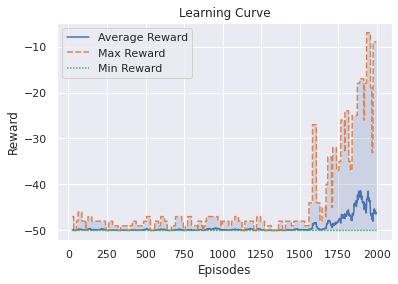

In [ ]:
import time

from gym import wrappers
import gym
import tianshou as ts
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger
from tianshou.exploration import GaussianNoise, OUNoise
from tianshou.policy import DDPGPolicy
import torch
from tianshou.utils.net.common import Net
from tianshou.utils.net.continuous import Actor, Critic
from gym.wrappers import FilterObservation, FlattenObservation

if __name__ == '__main__':
    start = time.perf_counter()
    env_id = "FetchReach-v1"
    seed = 0
    np.random.seed(seed)
    torch.manual_seed(seed)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    load_pretrained_model = False
    model_log_dir, model_file, buffer_file = '', '', ''

    # Logging directory
    model_name = 'Tianshou_DDPG'
    log_dir = 'logs/' + model_name + '_' + str(time.strftime('%d_%b_%Y_%H_%M_%S', time.localtime())) + '/'
    writer = SummaryWriter(log_dir=log_dir)
    logger = TensorboardLogger(writer, train_interval=1, update_interval=1)

    # Environment
    env = FlattenObservation(FilterObservation(gym.make(env_id)))
    env.seed(seed=seed)
    num_envs = 1

    train_envs = ts.env.DummyVectorEnv(
        [lambda: FlattenObservation(FilterObservation(gym.make(env_id))) for _ in range(num_envs)])
    test_envs = ts.env.DummyVectorEnv(
        [lambda: FlattenObservation(FilterObservation(gym.make(env_id))) for _ in range(num_envs)])
    train_envs.seed(seed)
    test_envs.seed(seed)

    # Neural networks and policy
    state_shape = env.observation_space.shape or env.observation_space.n
    action_shape = env.action_space.shape or env.action_space.n
    max_action = env.action_space.high[0]
    model_hyperparameters = {'hidden_sizes': [128, 128], 'learning_rate': 1e-3, 'estimation_step': 1}

    net_a = Net(state_shape, hidden_sizes=model_hyperparameters['hidden_sizes'], device=device)
    actor = Actor(net_a, action_shape, max_action=max_action, device=device).to(device)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=model_hyperparameters['learning_rate'])
    net_c = Net(state_shape, action_shape, hidden_sizes=model_hyperparameters['hidden_sizes'], concat=True,
                device=device)
    critic = Critic(net_c, device=device).to(device)
    critic_optim = torch.optim.Adam(critic.parameters(), lr=model_hyperparameters['learning_rate'])
    policy = DDPGPolicy(actor, actor_optim, critic, critic_optim,
                        exploration_noise=GaussianNoise(sigma=0.5 * max_action),
                        estimation_step=model_hyperparameters['estimation_step'],
                        action_space=env.action_space)


    # Collectors
    use_prioritised_replay_buffer = True
    prioritized_buffer_hyperparameters = {'total_size': 1_000_000, 'buffer_num': num_envs, 'alpha': 0.7, 'beta': 0.5}
    if use_prioritised_replay_buffer:
        train_collector = ts.data.Collector(policy, train_envs,
                                            ts.data.PrioritizedVectorReplayBuffer(**prioritized_buffer_hyperparameters),
                                            exploration_noise=True)
    else:
        train_collector = ts.data.Collector(policy, train_envs,
                                            ts.data.VectorReplayBuffer(
                                                total_size=prioritized_buffer_hyperparameters['total_size'] * num_envs,
                                                buffer_num=num_envs),
                                            exploration_noise=True)
    test_collector = ts.data.Collector(policy, test_envs, exploration_noise=False)


    # Test function
    def build_test_fn(num_episodes):
        def custom_test_fn(epoch, env_step):
            print(f"Epoch = {epoch}")

            # Save agent
            torch.save({'model': policy.state_dict(), 'actor_optim': actor_optim.state_dict(),
                        'critic1_optim': critic1_optim.state_dict()},
                       log_dir + model_name + f'_epoch{epoch}.pth')
            pickle.dump(train_collector.buffer, open(log_dir + f'epoch{epoch}_train_buffer.pkl', "wb"))

            # Record agents performance in video
            for episode in range(num_episodes // 2):
                env = ts.env.DummyVectorEnv(
                    [lambda: FlattenObservation(FilterObservation(gym.make(env_id))) for _ in range(1)])
                policy.eval()
                collector = ts.data.Collector(policy, env, exploration_noise=True)
                collector.collect_and_record = collect_and_record
                collector.collect_and_record(self=collector, video_dir=log_dir + f'epoch{epoch}/video{episode}/',
                                             n_episode=1, render=1 / 60)

            for episode in range(num_episodes // 2, num_episodes):
                env = ts.env.DummyVectorEnv(
                    [lambda: FlattenObservation(FilterObservation(gym.make(env_id))) for _ in range(1)])
                policy.eval()
                collector = ts.data.Collector(policy, env, exploration_noise=False)
                collector.collect_and_record = collect_and_record
                collector.collect_and_record(self=collector, video_dir=log_dir + f'epoch{epoch}/video{episode}/',
                                             n_episode=1, render=1 / 60)

        return custom_test_fn


    # Training
    trainer_hyperparameters = {'max_epoch': 1, 'step_per_epoch': 100_000, 'step_per_collect': 10,
                               'episode_per_test': 10, 'batch_size': 64}
    all_hypeparameters = dict(model_hyperparameters, **trainer_hyperparameters, **prioritized_buffer_hyperparameters)
    all_hypeparameters['seed'] = seed
    all_hypeparameters['use_prioritised_replay_buffer'] = use_prioritised_replay_buffer
    if load_pretrained_model:
        # Load model, optimisers and buffer
        checkpoint = torch.load(model_log_dir + model_file)
        policy.load_state_dict(checkpoint['model'])
        policy.actor_optim.load_state_dict(checkpoint['actor_optim'])
        policy.critic1_optim.load_state_dict(checkpoint['critic1_optim'])
        train_collector.buffer = pickle.load(open(model_log_dir + buffer_file, "rb"))
        all_hypeparameters['load_pretrained_model'] = load_pretrained_model
        all_hypeparameters['model_log_dir'] = model_log_dir
        all_hypeparameters['model_file'] = model_file
        all_hypeparameters['buffer_file'] = buffer_file
    save_dict_to_file(all_hypeparameters, path=log_dir)

    result = ts.trainer.offpolicy_trainer(policy, train_collector, test_collector, **trainer_hyperparameters,
                                          train_fn=None, test_fn=build_test_fn(num_episodes=8), stop_fn=None,
                                          logger=logger)
    print(f'Finished training! Use {result["duration"]}')

    # Learning Curve
    learning_curve_tianshou(log_dir=log_dir, window=25)

    # Record Episode Video
    num_episodes = 10
    for episode in range(num_episodes):
        env = ts.env.DummyVectorEnv([lambda: FlattenObservation(FilterObservation(gym.make(env_id))) for _ in range(1)])
        policy.eval()
        collector = ts.data.Collector(policy, env, exploration_noise=False)
        collector.collect_and_record = collect_and_record
        collector.collect_and_record(self=collector, video_dir=log_dir + f'final_agent/video{episode}/', n_episode=1,
                                     render=1 / 60)

    # Execution Time
    end = time.perf_counter()  # tensorboard --logdir './MuJoCo/FetchReach/logs'
    print(f"\nExecution time = {end - start:.2f} second(s)")

In [ ]:
!zip -r /content/DDPG_PER_logs.zip /content/logs

  adding: content/logs/ (stored 0%)
  adding: content/logs/Tianshou_DDPG_16_Feb_2022_10_17_49/ (stored 0%)
  adding: content/logs/Tianshou_DDPG_16_Feb_2022_10_17_49/epoch0/ (stored 0%)
  adding: content/logs/Tianshou_DDPG_16_Feb_2022_10_17_49/epoch0/video2/ (stored 0%)
  adding: content/logs/Tianshou_DDPG_16_Feb_2022_10_17_49/epoch0/video2/video.mp4 (deflated 6%)
  adding: content/logs/Tianshou_DDPG_16_Feb_2022_10_17_49/epoch0/video2/episode_stats.txt (stored 0%)
  adding: content/logs/Tianshou_DDPG_16_Feb_2022_10_17_49/epoch0/video6/ (stored 0%)
  adding: content/logs/Tianshou_DDPG_16_Feb_2022_10_17_49/epoch0/video6/video.mp4 (deflated 7%)
  adding: content/logs/Tianshou_DDPG_16_Feb_2022_10_17_49/epoch0/video6/episode_stats.txt (stored 0%)
  adding: content/logs/Tianshou_DDPG_16_Feb_2022_10_17_49/epoch0/video3/ (stored 0%)
  adding: content/logs/Tianshou_DDPG_16_Feb_2022_10_17_49/epoch0/video3/video.mp4 (deflated 7%)
  adding: content/logs/Tianshou_DDPG_16_Feb_2022_10_17_49/epoch0/vid

In [ ]:
from google.colab import files
files.download("/content/DDPG_PER_logs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>